# Step 1: Import and install packages

In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils
from transformers import BertModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
from matplotlib import rcParams
import seaborn as sns
import numpy as np
from PIL import Image
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from transformers import AutoTokenizer

# Step 2: Load data

In [2]:
# for dataset see: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets
fake_data=pd.read_csv("Fake.csv")
real_data=pd.read_csv("True.csv")

# Step 3: Data analysis

In [ ]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


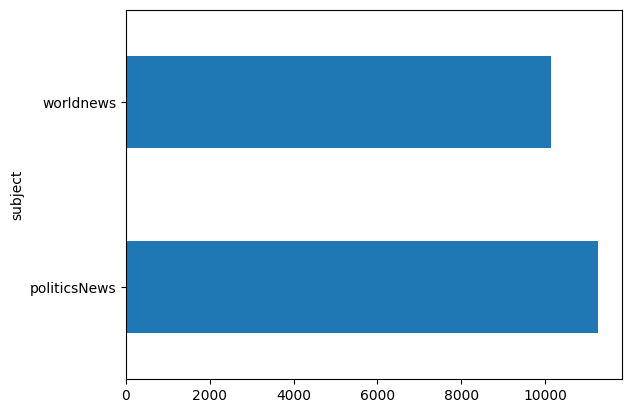

In [ ]:
# subject distribution of real news
real_data['subject'].value_counts().plot(kind='barh')
rcParams['figure.figsize'] = 5,5

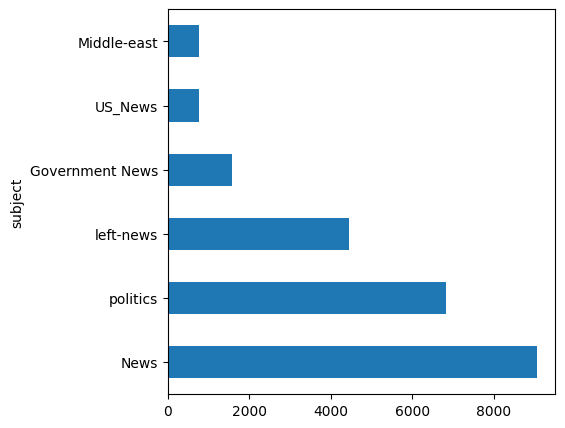

In [ ]:
# subject distribution of fake news
fake_data['subject'].value_counts().plot(kind='barh')
rcParams['figure.figsize'] = 5,5

## Wordcloud for real text data

In [ ]:
# for this picture see: https://user-images.githubusercontent.com/46570219/113926636-1630a300-97f5-11eb-8bf5-20723ebe27e0.png
wordcld_mask=np.array(Image.open("twitter.png"))
wordcld_text=" ".join(real_data["text"].tolist())

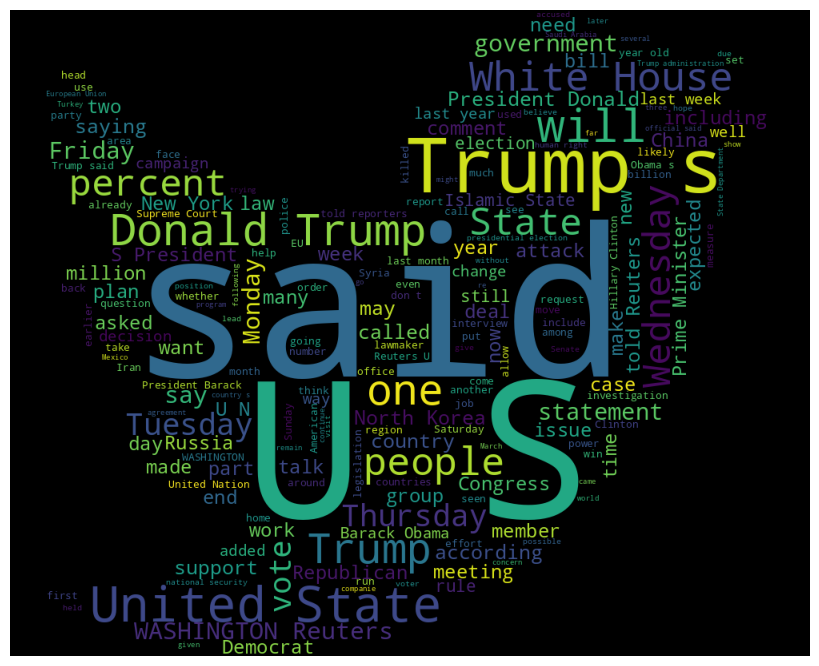

In [ ]:
wordcloud=WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(wordcld_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Wordcloud for fake text data

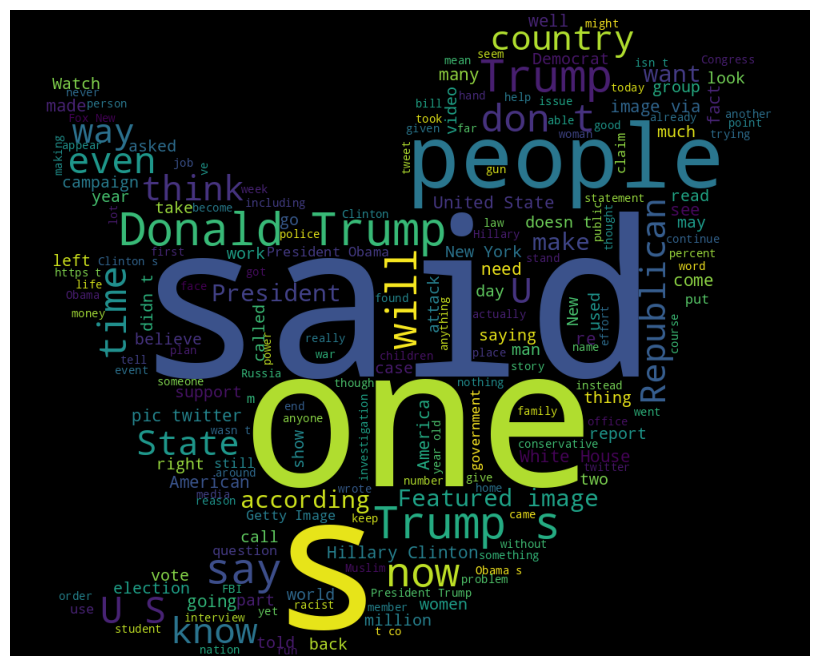

In [ ]:
fake_text=" ".join(fake_data["text"].tolist())
wordcloud=WordCloud(width=1920,height=1080,mask=wordcld_mask).generate(fake_text)
fig=plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Step 4: Preprocess

In [3]:
# add labels to news data
fake_data["label"]="fake"
real_data["label"]="real"

# concat real and fake news data
final_data= pd.concat([fake_data,real_data])

# reset index
final_data = final_data.sample(frac=1).reset_index(drop=True)

# drop columns with few contribution to the classification task
final_data.drop(["subject","date"], axis=1)

,title,text,label
0,DERANGED LEFTISTS Cross The Line: Chicago Play...,A play scheduled to open Saturday night in Chi...,fake
1,President Obama Defends Black Lives Matter Mo...,During a press conference in Spain Sunday morn...,fake
2,(VIDEO) CHICKEN LITTLE OBAMA CLAIMS CLIMATE CH...,THE CLIMATE CHANGE BS STARTS AROUND THE 16:00 ...,fake
3,LYING WHITE HOUSE PRESS SECRETARY: “OBAMA HAS ...,It s interesting that Josh Earnest still carri...,fake
4,REPORT: Aides Take Away Donald Trump’s Twitte...,Donald Trump s Twitter account is littered wit...,fake
...,...,...,...
44893,Freedom or 'fool's errand'? D.C. to vote on st...,WASHINGTON (Reuters) - Long-frustrated backers...,real
44894,Video: Hateful NYC ‘Artists’ Slip New ‘Items’ ...,Two NYC-based artists secretly slipped some it...,fake
44895,HAWAIIAN JUDGE WHO BLOCKED TRUMP WAS OBAMA’S C...,Activist judges are killing America! The judge...,fake
44896,WHOA: Clinton Just Effectively Sh*tcanned Deb...,If you re dissatisfied with Debbie Wasserman-S...,fake


<Axes: xlabel='label', ylabel='count'>

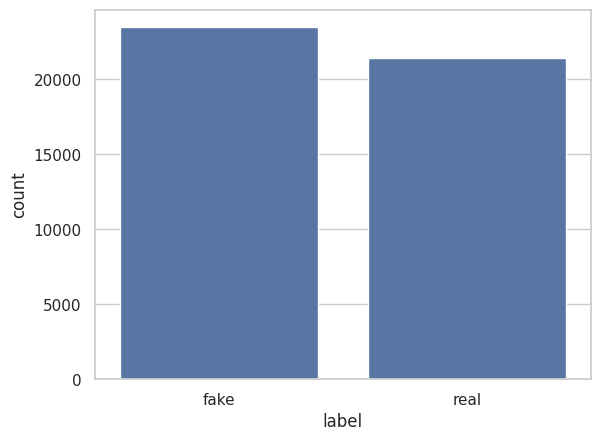

In [4]:
# visualize the distribution of fake and real news data
sns.set_theme(style="whitegrid")
sns.countplot(x=final_data["label"])

In [5]:
# combine text and title as a whole text column
final_data["text"]=final_data["title"]+final_data["text"]

# use only text and label column in the data
final_data=final_data[["text","label"]]

# map real and fake news label as 1 and 0
final_data['label'] = final_data['label'].map({'real':1, 'fake':0})

# take a look at final data
final_data.head(10)

<ipython-input-5-62c154a05a6b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['label'] = final_data['label'].map({'real':1, 'fake':0})


,text,label
0,DERANGED LEFTISTS Cross The Line: Chicago Play...,0
1,President Obama Defends Black Lives Matter Mo...,0
2,(VIDEO) CHICKEN LITTLE OBAMA CLAIMS CLIMATE CH...,0
3,LYING WHITE HOUSE PRESS SECRETARY: “OBAMA HAS ...,0
4,REPORT: Aides Take Away Donald Trump’s Twitte...,0
5,Germany's Merkel says Paris climate accord is ...,1
6,Alabama Republican House Speaker Removed From...,0
7,"“We choose the nominee, not the people” – GOP ...",0
8,"Protesters face off in downtown Cleveland, sep...",1
9,"Britain, Germany committed to Iran nuclear dea...",1


In [17]:
# define the max length of token
max_len=100

# sample the data to boost training
data_0 = final_data[final_data["label"] == 0].sample(n=100, random_state=42)

data_1 = final_data[final_data["label"] == 1].sample(n=100, random_state=42)

balanced_data = pd.concat([data_0, data_1]).reset_index(drop=True)

data_text = balanced_data["text"]
data_label = balanced_data["label"]

# split the data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((160,), (40,), (160,), (40,))

# Step 5: Model training

In [7]:
# get pre-trained model
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [15]:
# tokenization function
def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

In [18]:
# tokenize training and testing data
X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

## Create Bert model


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model

# bert layer
class BertLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = bert_model

    # get pooled output for classification
    def call(self, inputs):
        return self.bert(inputs)[1]

# define our own create model function
def create_model(bert_model, maxlen=100):
    # input for bert of shape (batch_size, maxlen)
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
    # attention mask for bert model
    attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")

    # get the pooled output for bert layer
    bert_layer = BertLayer(bert_model)
    pooled_output = bert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})

    # define our own layer for classification (fine-tune)
    # randomly dropout 50% of neurons while training to avoid overfit
    x = Dropout(0.5)(pooled_output)
    # transform and activate
    x = Dense(64, activation="tanh")(x)
    # dropout again
    x = Dropout(0.5)(x)
    # transform into probability from 0-1
    output = Dense(1, activation="sigmoid")(x)

    # return our model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

# Create the model
model = create_model(bert_model)

# Display the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_ids (InputLayer)    │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_layer (BertLayer)    │ (None, 768)            │              0 │ attention_mask[0][0],  │
│                           │                        │                │ input_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 768)            │              0 │ bert_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │         49,216 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,281 (192.50 KB)

 Trainable params: 49,281 (192.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# optimizer, learning rate and other hyperparameters
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric you want to monitor
    patience=3,  # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)
# use ReduceLROnPlateau for changing learning rate while training for quicker converge
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduce the learning rate by a factor of 0.1
    patience=3,  # Number of epochs with no improvement to wait before reducing the learning rate
    verbose=1,
    min_lr=1e-6  # Minimum learning rate
)

# compile our model before using it
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


## Kfold

In [19]:
from sklearn.model_selection import KFold
import numpy as np

# initialize KFold of 5 fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# store the training result for each fold
fold_history = []
val_accuracies = []
val_losses = []

# transform data into numpy array
X_input_ids = np.array(X_train_token['input_ids'])
X_attention_mask = np.array(X_train_token['attention_mask'])
Y_train_np = Y_train.to_numpy()  # Convert Y_train to NumPy array

# iterate through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_input_ids)):
    print(f"\nTraining on Fold {fold + 1}/{kf.n_splits}")

    # training data
    X_train = {
        'input_ids': X_input_ids[train_idx],
        'attention_mask': X_attention_mask[train_idx]
    }
    Y_train = Y_train_np[train_idx]

    # validation data
    X_val = {
        'input_ids': X_input_ids[val_idx],
        'attention_mask': X_attention_mask[val_idx]
    }
    Y_val = Y_train_np[val_idx]

    # create a new model for each fold
    model = create_model(bert_model, maxlen=100)
    # compile the model before using
    optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, decay=0.01,clipnorm=1.0)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

    # train and record the history of training
    history = model.fit(
        x=X_train,
        y=Y_train,
        epochs=20,
        batch_size=30,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping, reduce_lr]
    )

    # acc and loss for current fold
    val_loss, val_acc = model.evaluate(X_val, Y_val, verbose=0)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # append the history into the result
    fold_history.append(history.history)

# Kfold average acc and loss
avg_val_loss = np.mean(val_losses)
avg_val_acc = np.mean(val_accuracies)

print("K-Fold Cross-Validation Results:")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_acc:.4f}")

print("K-Fold Training Complete")


Training on Fold 1/5
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 13s/step - accuracy: 0.4734 - loss: 0.9762 - val_accuracy: 0.5625 - val_loss: 0.6983 - learning_rate: 1.0000e-05
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 66s 14s/step - accuracy: 0.5347 - loss: 0.8874 - val_accuracy: 0.5625 - val_loss: 0.6940 - learning_rate: 1.0000e-05
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 12s/step - accuracy: 0.5245 - loss: 0.9234 - val_accuracy: 0.5625 - val_loss: 0.6907 - learning_rate: 1.0000e-05

Training on Fold 2/5
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 76s 12s/step - accuracy: 0.5100 - loss: 0.7524 - val_accuracy: 0.5625 - val_loss: 0.6885 - learning_rate: 1.0000e-05
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 66s 14s/step - accuracy: 0.5564 - loss: 0.7967 - val_accuracy: 0.5625 - val_loss: 0.6882 - learning_rate: 1.0000e-05
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 11s/step - accuracy: 0.4892 - loss: 0.8612 - val_accuracy: 0.5625 - val_loss: 0.6880 - learning_rate: 1.0000e-05

Training on Fold 3/5
Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 77s 12s/step 

## Original version

In [ ]:
# train and record history of training
history = model.fit(
    x={
        'input_ids': X_train_token['input_ids'],
        'attention_mask': X_train_token['attention_mask']
    },
    y=Y_train,
    epochs=20,
    batch_size=30,
    validation_data=(
        {
            'input_ids': X_test_token['input_ids'],
            'attention_mask': X_test_token['attention_mask']
        },
        Y_test
    ),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 433s 15s/step - accuracy: 0.4870 - loss: 0.8576 - val_accuracy: 0.5750 - val_loss: 0.6879 - learning_rate: 1.0000e-05
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 421s 16s/step - accuracy: 0.4644 - loss: 0.8596 - val_accuracy: 0.5650 - val_loss: 0.6869 - learning_rate: 1.0000e-05
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 435s 16s/step - accuracy: 0.5416 - loss: 0.8254 - val_accuracy: 0.5050 - val_loss: 0.6862 - learning_rate: 1.0000e-05
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 506s 18s/step - accuracy: 0.4760 - loss: 0.8357 - val_accuracy: 0.5150 - val_loss: 0.6854 - learning_rate: 1.0000e-05
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 502s 18s/step - accuracy: 0.4950 - loss: 0.8516 - val_accuracy: 0.5050 - val_loss: 0.6850 - learning_rate: 1.0000e-05
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 439s 15s/step - accuracy: 0.5237 - loss: 0.7992 - val_accuracy: 0.5150 - val_loss: 0.6847 - learning_rate: 1.0000e-05
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 434s 15s/step - accuracy: 

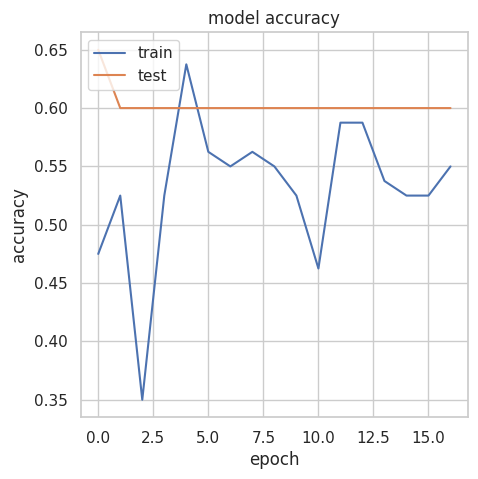

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

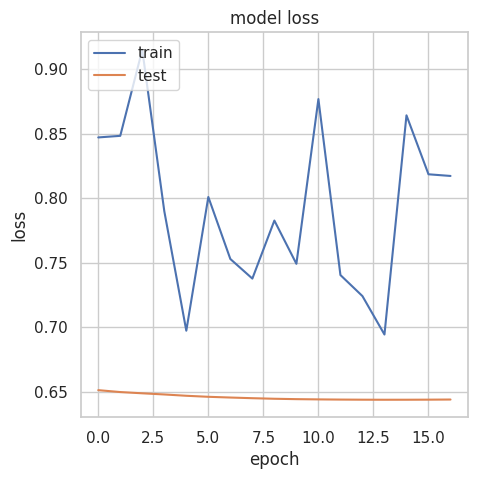

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Make predictions
y_pred_proba = model.predict({
    'input_ids': X_test_token['input_ids'],
    'attention_mask': X_test_token['attention_mask']
})

# Convert probabilities to binary predictions
y_pred = np.where(y_pred_proba >= 0.5, 1, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


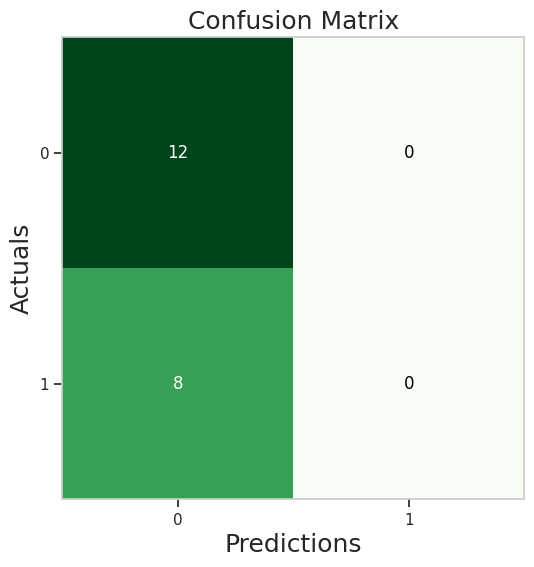

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(Y_test,y_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.60      1.00      0.75        12
           1       0.00      0.00      0.00         8

    accuracy                           0.60        20
   macro avg       0.30      0.50      0.38        20
weighted avg       0.36      0.60      0.45        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


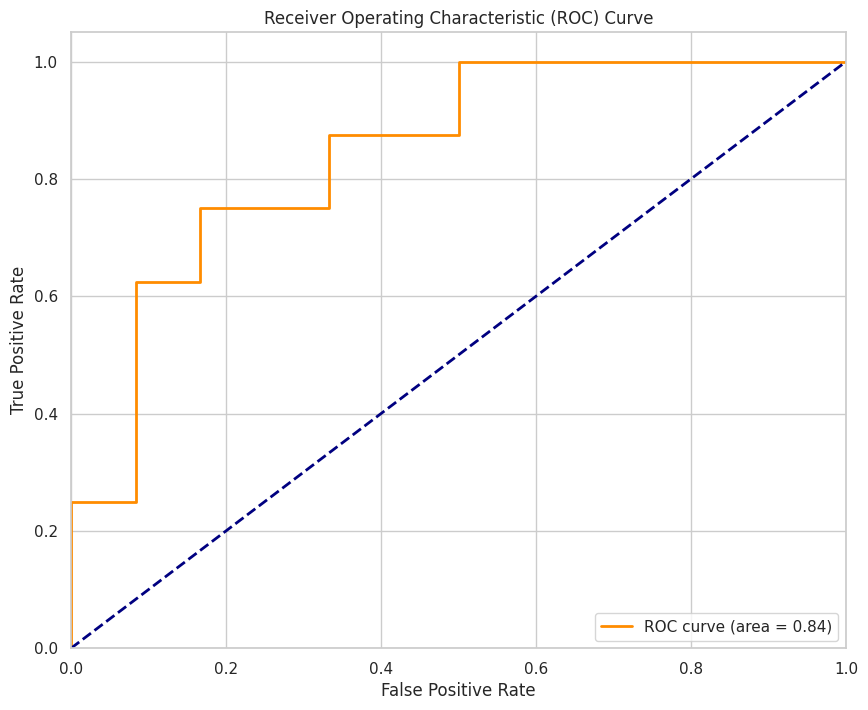

In [ ]:
from sklearn.metrics import roc_curve, auc


y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask']
    }
)

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)  # Removed indexing on y_pred_prob
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


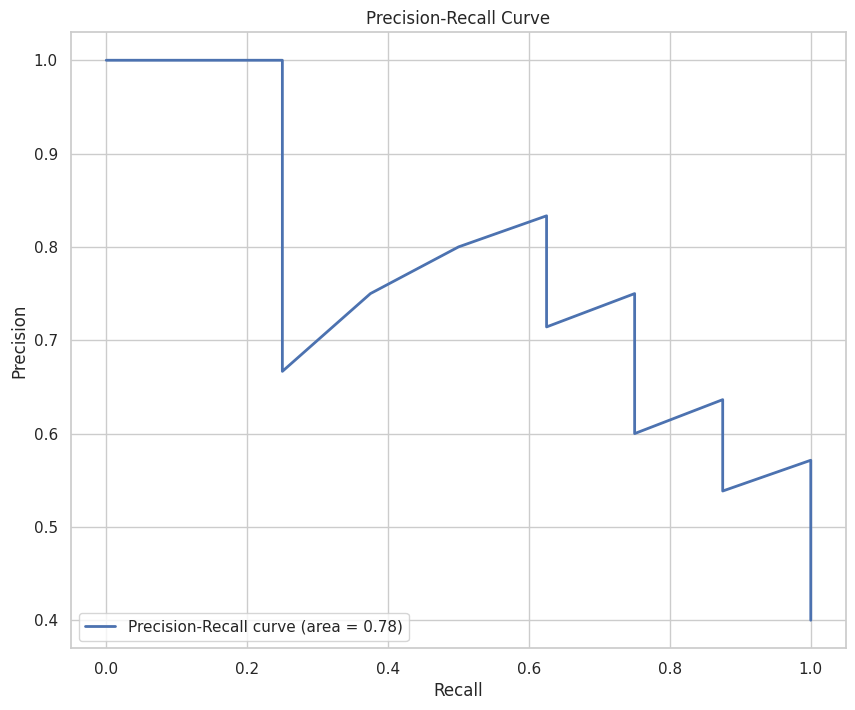

In [ ]:
from sklearn.metrics import precision_recall_curve, auc


y_pred_prob = model.predict(
    {
        'input_ids': X_test_token['input_ids'],
        'attention_mask': X_test_token['attention_mask']
    }
)

precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10,8))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()